In [59]:
import numpy as np
import pandas as pd
import os

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

#machine learning libraries
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#model selection
from sklearn.model_selection import train_test_split,GridSearchCV

#metrics
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,precision_score,recall_score,f1_score,balanced_accuracy_score,accuracy_score
from sklearn import metrics

pd.set_option("display.max_columns",None)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Pipeline
from sklearn import pipeline


# Loading the data

In [60]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [61]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Exploratory Data Analysis

Let's see the basic statistics of our data

In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Here we have 9 categorical features. The rest are ordinal or continuous values.

Let's look at the categorical columns

In [64]:
categories = df.select_dtypes([object]).columns
print(categories)

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


In [65]:
df.select_dtypes([object]).head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


Let's look at the unique values of each category.

In [66]:
for i in df.select_dtypes([object]).columns:
    print(i,":",df[i].unique())

Attrition : ['Yes' 'No']
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department : ['Sales' 'Research & Development' 'Human Resources']
EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender : ['Female' 'Male']
JobRole : ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus : ['Single' 'Married' 'Divorced']
Over18 : ['Y']
OverTime : ['Yes' 'No']


| Feature | Comment |
| --- | --- |
| **Attrition** | This is the label of interest. We will convert this to a binary variable {1: yes, 0: no} |
| **BusinessTravel** | We will convert this to an ordinal variable {0: Non-Travel, 1: Travel_Rarely, 2: Travel_Frequently} |
| **Department** | This is purely categorical, so we will have to one-hot encode or convert to a dummy variable |
| **EducationField** | This is purely categorical, so we will have to one-hot encode or convert to a dummy variable |
| **Gender** | There are only 2 values in the dataset, so we can convert this to a binary variable. This is legally protected data, so we have to be careful that using this feature does not lead to any forms of gender discrimination. |
| **JobRole** | This is purely categorical, so we will have to one-hot encode or convert to a dummy variable. This category has a decent number of values. By converting it, we are increasing our dimensionality by 9. This could lead to the curse of dimensionality. |
| **MaritalStatus** | Categorical, but one could make the case to make it ordinal. If we made it ordinal, then the mapping would be {0: Single, 1: Married, 2: Divorced}. Again, we have to be careful as using this information to make a hiring decision would be illegal. The likely option is to drop the column. |
| **Over18** | This feature only has 1 value, so we will drop it. |
| **OverTime** | We will convert this to a binary variable {0: No, 1: Yes} |

For now we are transforming the ordinal features into their numeric typed columns and drop the constant column.

#### Dropped below columns (EmployeeCount,Over18,StandardHours) because it's only has one value for all rows. Also dropping EmployeeNumber.

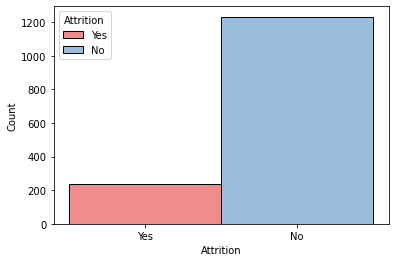

In [67]:
sns.histplot(df,x="Attrition",hue="Attrition",palette="Set1")
plt.show()

The labels are very unbalanced. This will lead to problems with misclassification of the yes values and overfitting.

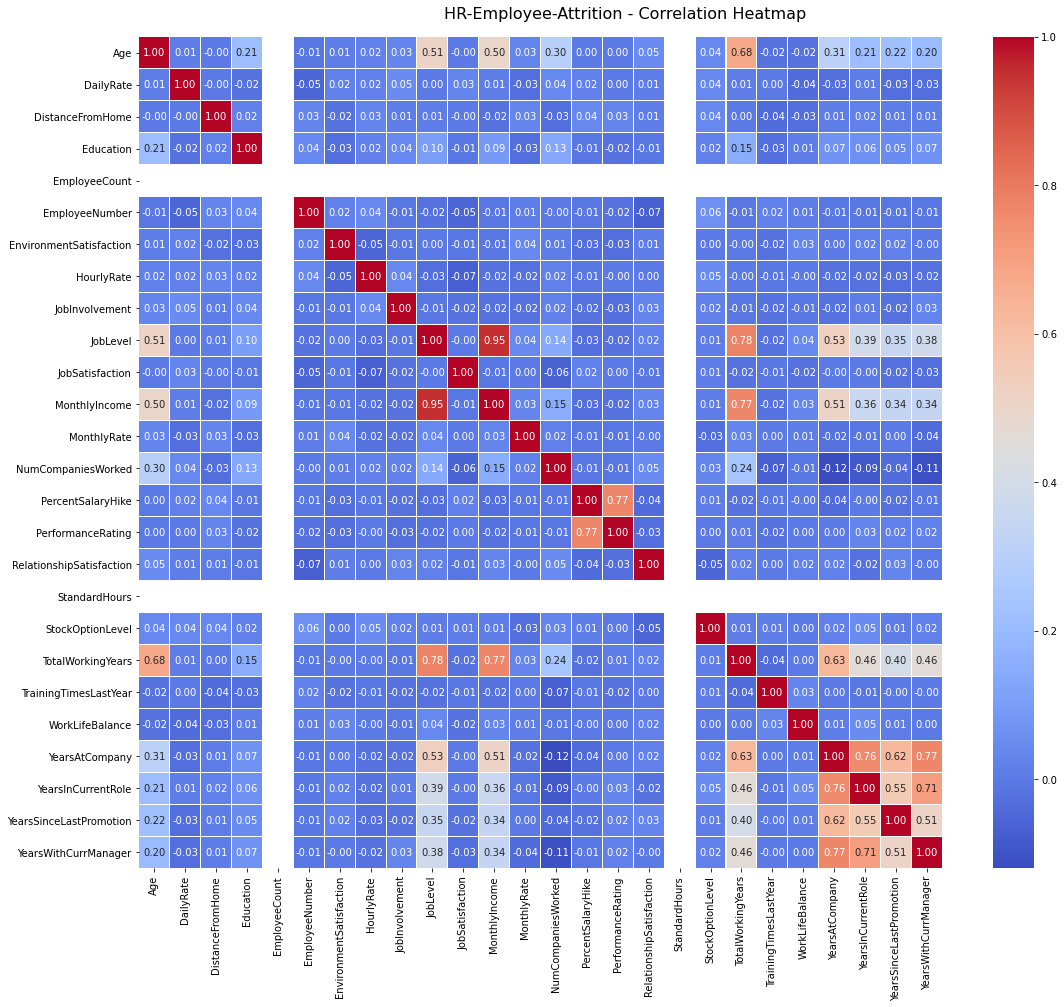

In [68]:
# Correlation Plot
f, ax = plt.subplots(figsize=(18, 14))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.95)
t= f.suptitle('HR-Employee-Attrition - Correlation Heatmap', fontsize=16)

#### We can see from the correlation plot that Attrition does not have strong correlation with any other variables. We can also see from the correlation plot that only few variables have relatively strong correlation. Job Level and Monthly Income has highest correlation of 0.95. 

#### Some other correlated variables are as follows: 
- TotalWorkingYears and Monthly Income (0.78)
- Age and TotalWorkingYears (0.68)
- YearsAtComapny and YearsWithCurrManager (0.77)
- YearsInCurrentRole and YearsWithCurrManager (0.71)
- YearsInCurrentRole and YearsAtCompany (0.76)

#### but these do not have a high enough correlation to be candidates to drop

Text(0.5, 0, 'Age')

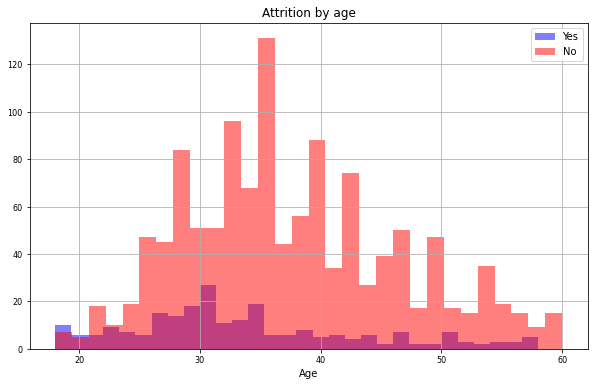

In [19]:
fig = plt.figure(figsize=(10, 6))
(df[df['Attrition'] == "Yes"]['Age']).hist(bins=30, color='blue', linewidth=1.0,alpha=0.5, label = 'Yes',
              xlabelsize=8, ylabelsize=8, grid=True)  
(df[df['Attrition'] == "No"]['Age']).hist(bins=30, color='red', linewidth=1.0,alpha=0.5,label = 'No',
              xlabelsize=8, ylabelsize=8, grid=True)  
plt.legend()
plt.title("Attrition by age")
plt.xlabel("Age")

#### Younger employees were more likely to leave

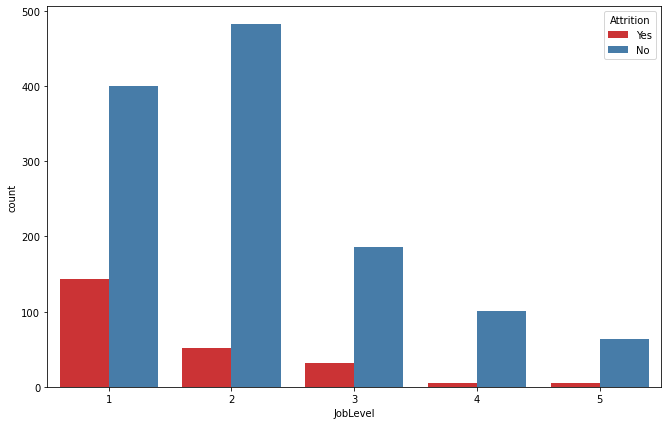

In [20]:
plt.figure(figsize=[11,7])
ax = sns.countplot(x="JobLevel", hue="Attrition", data=df, palette="Set1")

Performing a groupby, we can get the percent attrition rate by job level.

In [23]:
df[["Attrition","JobLevel"]].groupby(["JobLevel","Attrition"]).size().groupby(level=[0]).apply(lambda x: np.round(x/x.sum(),2))

JobLevel  Attrition
1         No           0.74
          Yes          0.26
2         No           0.90
          Yes          0.10
3         No           0.85
          Yes          0.15
4         No           0.95
          Yes          0.05
5         No           0.93
          Yes          0.07
dtype: float64

At a lower job level, an employee is more likely to leave the company.

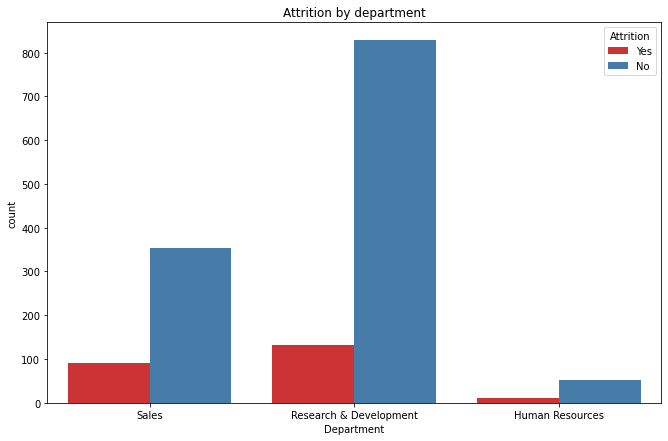

In [26]:
plt.figure(figsize=[11,7])
ax = sns.countplot(x="Department", hue="Attrition", data=df, palette="Set1")
ax.set_title("Attrition by department")
plt.show()

In [30]:
df[["Department","Attrition"]].groupby(["Department","Attrition"]).size().groupby(level=[0]).apply(lambda x: np.round(x/x.sum(),2))

Department              Attrition
Human Resources         No           0.81
                        Yes          0.19
Research & Development  No           0.86
                        Yes          0.14
Sales                   No           0.79
                        Yes          0.21
dtype: float64

#### Sales and HR have higher attrition rates compared to research and development  department

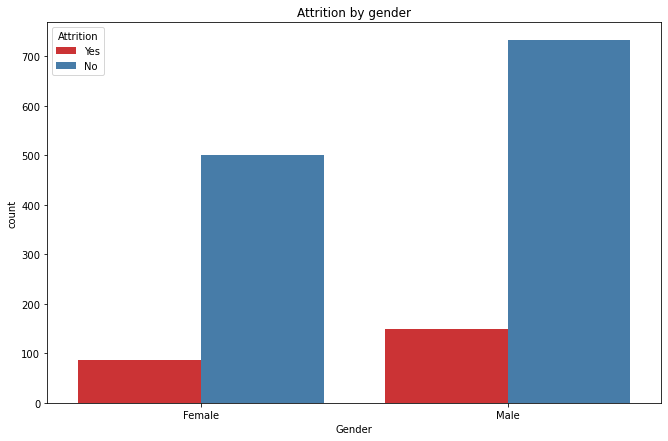

In [31]:
plt.figure(figsize=[11,7])
ax = sns.countplot(x="Gender", hue="Attrition", data=df, palette="Set1")
ax.set_title("Attrition by gender")
plt.show()

In [32]:
round(df[["Gender","Attrition"]].groupby(["Gender","Attrition"]).size().groupby(level=0).apply(lambda x: x/x.sum()),2)


Gender  Attrition
Female  No           0.85
        Yes          0.15
Male    No           0.83
        Yes          0.17
dtype: float64

#### Males were found to be slighty more likely to leave

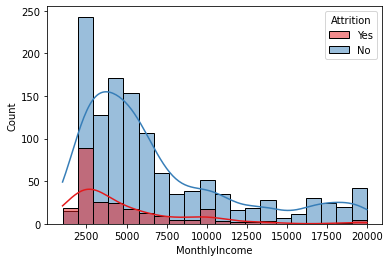

In [43]:
sns.histplot(df,x="MonthlyIncome",hue="Attrition",kde=True,palette="Set1")
plt.show()

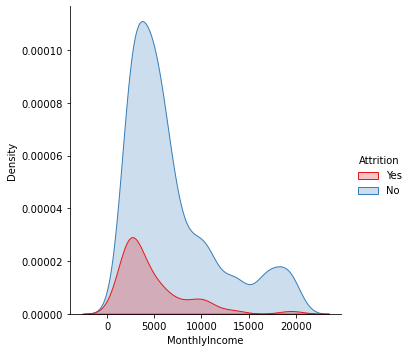

In [45]:
sns.displot(df,x="MonthlyIncome",hue="Attrition",kind="kde",palette="Set1",fill=True)
plt.show()

#### Attrition rate is higher at lower monthly income 

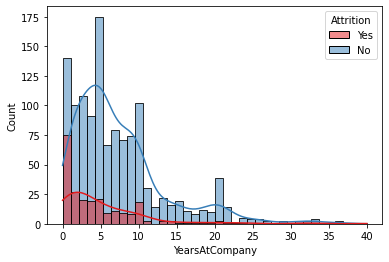

In [46]:
sns.histplot(df,x="YearsAtCompany",hue="Attrition",kde=True,palette="Set1")
plt.show()

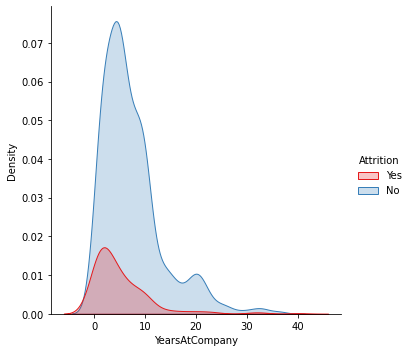

In [47]:
sns.displot(df,x="YearsAtCompany",hue="Attrition",kind="kde",palette="Set1",fill=True)
plt.show()

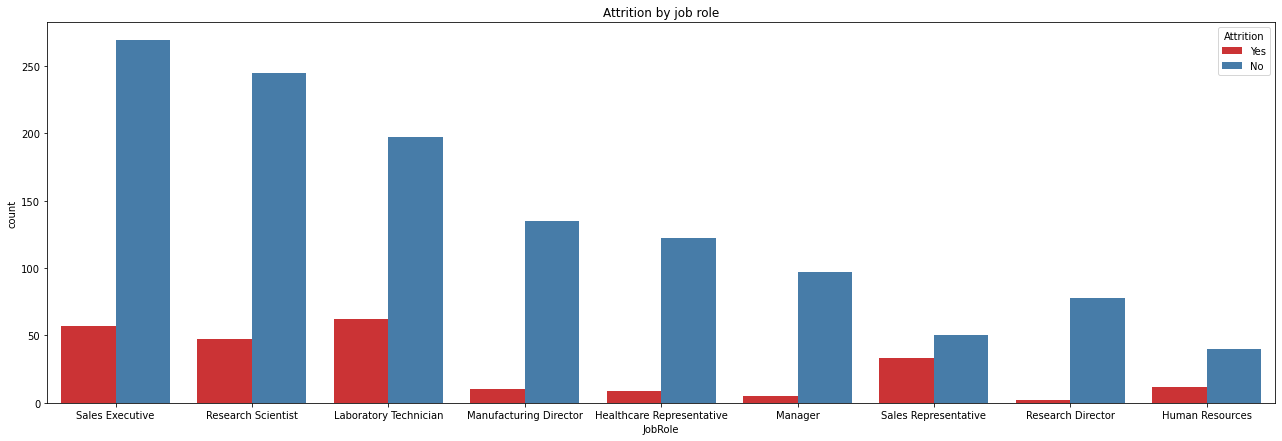

In [48]:
plt.figure(figsize=[22,7])
ax = sns.countplot(x="JobRole", hue="Attrition", data=df, palette="Set1")
ax.set_title("Attrition by job role")
plt.show()

In [50]:
round(df[["JobRole","Attrition"]].groupby(["JobRole","Attrition"]).size().groupby(level=0).apply(lambda x: x/x.sum()),2)

JobRole                    Attrition
Healthcare Representative  No           0.93
                           Yes          0.07
Human Resources            No           0.77
                           Yes          0.23
Laboratory Technician      No           0.76
                           Yes          0.24
Manager                    No           0.95
                           Yes          0.05
Manufacturing Director     No           0.93
                           Yes          0.07
Research Director          No           0.98
                           Yes          0.02
Research Scientist         No           0.84
                           Yes          0.16
Sales Executive            No           0.83
                           Yes          0.17
Sales Representative       No           0.60
                           Yes          0.40
dtype: float64

#### Sales Representative and Lab Technicain have higher attrition rate

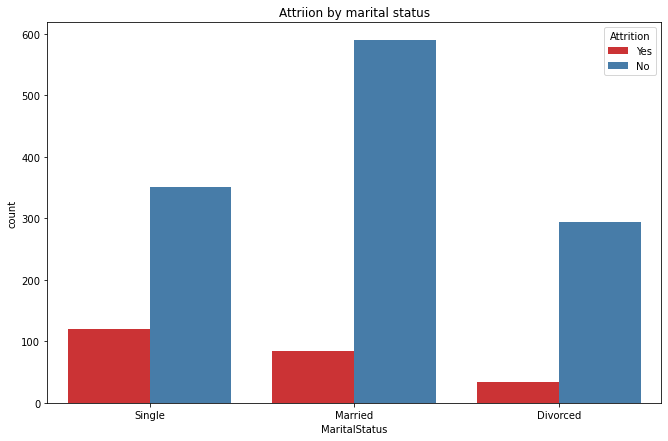

In [51]:
plt.figure(figsize=[11,7])
ax = sns.countplot(x="MaritalStatus", hue="Attrition", data=df, palette="Set1")
ax.set_title("Attriion by marital status")
plt.show()

In [52]:
round(df[["MaritalStatus","Attrition"]].groupby(["MaritalStatus","Attrition"]).size().groupby(level=0).apply(lambda x: x/x.sum()),2)

MaritalStatus  Attrition
Divorced       No           0.90
               Yes          0.10
Married        No           0.88
               Yes          0.12
Single         No           0.74
               Yes          0.26
dtype: float64

#### Employees who are single have higher rates of attrition compared to married and divorced workers  

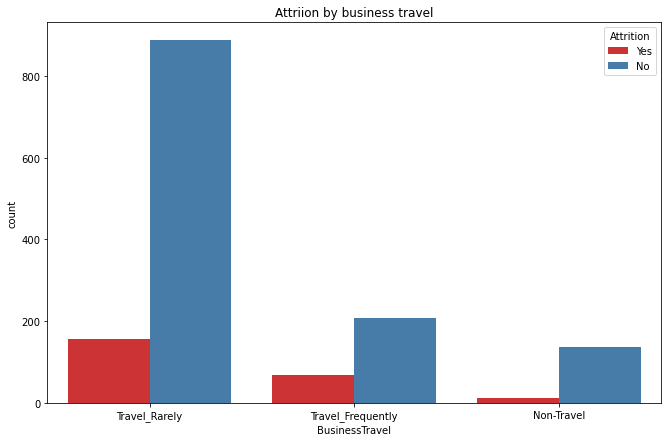

In [53]:
plt.figure(figsize=[11,7])
ax = sns.countplot(x="BusinessTravel", hue="Attrition", data=df, palette="Set1")
ax.set_title("Attriion by business travel")
plt.show()

In [54]:
round(df[["BusinessTravel","Attrition"]].groupby(["BusinessTravel","Attrition"]).size().groupby(level=0).apply(lambda x: x/x.sum()),2)

BusinessTravel     Attrition
Non-Travel         No           0.92
                   Yes          0.08
Travel_Frequently  No           0.75
                   Yes          0.25
Travel_Rarely      No           0.85
                   Yes          0.15
dtype: float64

#### Employees who travel frequently have higher attrition rates than who travel rarely or didn’t travel at all 

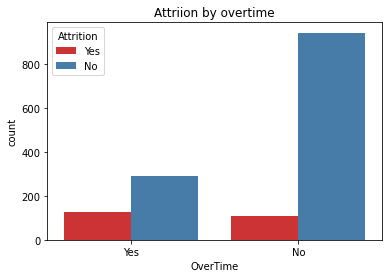

In [56]:
ax = sns.countplot(x="OverTime", hue="Attrition", data=df, palette="Set1")
ax.set_title("Attriion by overtime")
plt.show()

In [58]:
df[["OverTime","Attrition"]].groupby(["OverTime","Attrition"]).size().groupby(level=0).apply(lambda x: np.round(x/x.sum(),2))

OverTime  Attrition
No        No           0.90
          Yes          0.10
Yes       No           0.69
          Yes          0.31
dtype: float64

Employee

# Data transform

Convert some categories to ordinal values

In [69]:
df["Attrition"] = df["Attrition"].map({"No": 0, "Yes": 1})
df["BusinessTravel"] = df["BusinessTravel"].map({"Non-Travel": 0, "Travel_Rarely": 1,"Travel_Frequently": 2})
df["OverTime"] = df["OverTime"].map({"No": 0, "Yes": 1})
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})

In [55]:
cat_feats =  ['Department', 'EducationField', 'JobRole', 'MaritalStatus']

Create the dummy variables

In [70]:
# Converting categorical variables to dummy variables
df = pd.get_dummies(df, columns = cat_feats)

Drop columns

In [72]:
df = df.drop(["Over18","StandardHours","EmployeeCount","EmployeeNumber"],axis=1)

In [ ]:
features = xg_df.drop(["Attrition"],axis=1)
label = xg_df["Attrition"]
xg_x_train,xg_x_val,xg_y_train,xg_y_val = train_test_split(features,label,train_size=0.8,random_state=1,shuffle=True,stratify=label)

### Preparing data from machine learning

In [74]:
X = df.drop('Attrition', axis = 1)
y = df['Attrition']
X.shape

(1470, 47)

Create the train-test split

In [76]:
# Trai, Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y, test_size=0.20, random_state=1)

scale the data

In [77]:
# Standardization of the data
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)

# Helper functions

In [50]:
def training_run_classification(model,parameters,X_train,y_train,X_val,y_val,scoring=None):
    cv_str = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv = GridSearchCV(model,parameters,cv=cv_str,n_jobs=-1,scoring=scoring)
    cv.fit(X_train,y_train)
    model = cv.best_estimator_
    print(cv.best_params_)
    pred = model.predict(X_val)
    cm = confusion_matrix(y_val,pred)
    acc = accuracy_score(y_val,pred)
    balanced_accuracy = balanced_accuracy_score(y_val,pred)
    precision = precision_score(y_val,pred)
    recall = recall_score(y_val,pred)
    f1 = f1_score(y_val,pred)
    specificity = cm[0,0]/np.sum(cm[0])
    
    print(f"Accuracy: {acc}")
    print(f"Balanced Accuracy: {balanced_accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"f1: {f1}")
    print(f"Specificity: {specificity}")
    plot_confusion_matrix(model,X_val,y_val)
    plt.show()

    results = {
        "Accuracy": {acc},
        "Balanced" Accuracy: {balanced_accuracy},
        "Precision": {precision},
        "Recall": {recall},
        "f1": {f1},
        "Specificity": {specificity},
    }

    return model, results

# ADABoost

{'learning_rate': 1, 'n_estimators': 100}
Accuracy: 0.8458049886621315
Balanced Accuracy: 0.6633993148077655
Precision: 0.5283018867924528
Recall: 0.39436619718309857
f1: 0.4516129032258064
Specificity: 0.9324324324324325


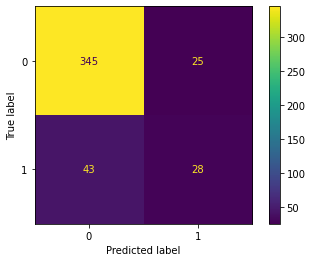

In [51]:
parameters = {
    'n_estimators': [50,100,200,300],
    'learning_rate': [0.1,0.2,1,2],
}
adabc, adabc_results = training_run_classification(AdaBoostClassifier(),parameters,X_train,y_train,X_val,y_val,scoring="balanced_accuracy")

# SVC - Support vector machine Classifier

Fit Linear RBF Kernel SVM Classifier

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.854875283446712
Balanced Accuracy: 0.6744956223829464
Precision: 0.5686274509803921
Recall: 0.4084507042253521
f1: 0.47540983606557374
Specificity: 0.9405405405405406


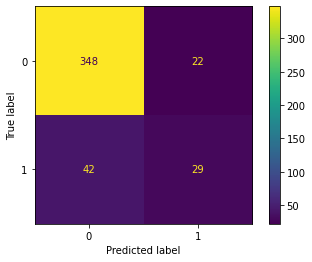

In [52]:
parameters = {
    'gamma': [0.1,0.01,0.001,0.0001],
    'C': [1,10,100,1000],
    'kernel':['rbf'] # Removing linear kernel as rbf is giving better result
}

svc, svc_results = training_run_classification(SVC(),parameters,X_train,y_train,X_val,y_val,scoring="balanced_accuracy")

# XGBoost

The XGBoost dataset does not work as well with the scaled transform. Using the original scaling makes a slightly better model.

In [53]:
path = os.path.join("WA_Fn-UseC_-HR-Employee-Attrition.csv")
xg_df = pd.read_csv(path)
xg_df["Attrition"] = xg_df["Attrition"].map({"No": 0, "Yes": 1})
xg_df["BusinessTravel"] = xg_df["BusinessTravel"].map({"Non-Travel": 0, "Travel_Rarely": 1,"Travel_Frequently": 2})
xg_df["OverTime"] = xg_df["OverTime"].map({"No": 0, "Yes": 1})
xg_df["Gender"] = xg_df["Gender"].map({"Male": 0, "Female": 1})
xg_df = xg_df.drop(["Over18","StandardHours","EmployeeCount","MaritalStatus"],axis=1)
xg_df = pd.get_dummies(xg_df,columns=["Department","EducationField","JobRole"])
features = xg_df.drop(["Attrition"],axis=1)
label = xg_df["Attrition"]
xg_x_train,xg_x_val,xg_y_train,xg_y_val = train_test_split(features,label,train_size=0.8,random_state=1,shuffle=True,stratify=label)

[17:33:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'learning_rate': 1, 'max_depth': None, 'n_estimators': 25, 'n_jobs': -1, 'random_state': 1, 'reg_alpha': 10, 'reg_lambda': 1, 'scale_pos_weight': 3, 'tree_method': 'approx'}
Accuracy: 0.8775510204081632
Balanced Accuracy: 0.8237574295804979
Precision: 0.5932203389830508
Recall: 0.7446808510638298
f1: 0.6603773584905661
Specificity: 0.902834008097166


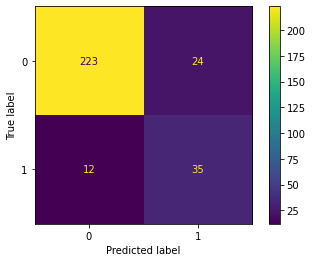

In [54]:
parameters = {
    "n_estimators": [25],
    "max_depth": [None],
    "learning_rate": [1],
    "booster": ["gbtree"],
    "tree_method": ["approx"],
    "n_jobs": [-1],
    "reg_alpha": [10],
    "reg_lambda": [1],
    "scale_pos_weight": [3],
    "random_state": [1]
}

xgb, xgb_results = training_run_classification(XGBClassifier(),parameters,xg_x_train,xg_y_train,xg_x_val,xg_y_val,scoring="precision")

# XGBoost forest

[17:33:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 200, 'random_state': 1, 'reg_alpha': 10, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 1, 'tree_method': 'exact', 'use_label_encoder': False}
Accuracy: 0.8537414965986394
Balanced Accuracy: 0.7923593763459384
Precision: 0.532258064516129
Recall: 0.7021276595744681
f1: 0.6055045871559632
Specificity: 0.8825910931174089


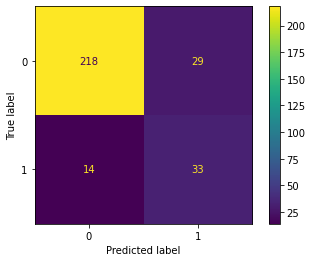

In [55]:
parameters = {
    "n_estimators": [200],
    "use_label_encoder": [False],
    "learning_rate": [0.01],
    "booster": ["gbtree"],
    "tree_method": ["exact"],
    "subsample": [1],
    "colsample_bytree": [1],
    "colsample_bylevel": [0.8,1],
    "colsample_bynode": [0.6,0.8],
    "reg_alpha": [10],
    "reg_lambda": [1],
    "scale_pos_weight": [3],
    "random_state": [1]
}

xgb_rf, xgb_rf_results = training_run_classification(XGBRFClassifier(),parameters,xg_x_train,xg_y_train,xg_x_val,xg_y_val,scoring="precision")

# Random Forest 

{'n_estimators': 1000}
Accuracy: 0.8571428571428571
Balanced Accuracy: 0.5904834411876666
Precision: 0.7
Recall: 0.19718309859154928
f1: 0.3076923076923077
Specificity: 0.9837837837837838


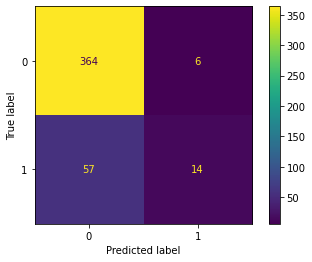

In [56]:
parameters = {
    "n_estimators": [1000]
}

forest, forest_results = training_run_classification(RandomForestClassifier(),parameters,X_train,y_train,X_val,y_val,scoring="precision")

# Gradient Boosting

{'learning_rate': 0.25, 'max_depth': 2, 'max_features': 2, 'n_estimators': 20}
Accuracy: 0.8616780045351474
Balanced Accuracy: 0.5818043395508185
Precision: 0.8571428571428571
Recall: 0.16901408450704225
f1: 0.2823529411764706
Specificity: 0.9945945945945946


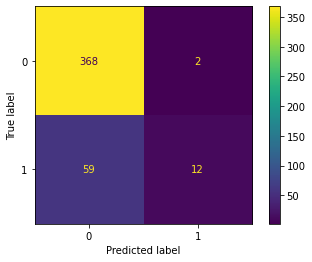

In [57]:
parameters = {
    'learning_rate' : [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'n_estimators': [20], 
    'max_features' : [2],
    'max_depth' : [2]
}

gb, gb_results = training_run_classification(GradientBoostingClassifier(),parameters,X_train,y_train,X_val,y_val,scoring="precision")

In [ ]:
pd.DataFrame([adabc_results,svc_results,xgb_results,xgb_rf_results,forest_results,gb_results])